Thanks for taking the time to look at my code! If you don't have an Nvidia GPU, You will need to replace any instances of "cp_smallest_sample_size" with "get_smallest_sample_size". The cupy code runs roughly 5 times faster than the numpy code.

In [125]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import cupy as cp
from collections import defaultdict

In [2]:
def load_data(filepath):
    df = pd.read_pickle(filepath)
    return df

In [28]:
def split_by_event(df, columns=None):
    ''' Groups data into separate dataframes by data collection event.
    INPUTS: df: pandas DataFrame
            columns (optional): Array-like referring to the desired column names.
                                Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: df_dict: a dictionary of DataFrames or arrays where each key refers to a single data gathering event.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for time_period in df['Even_mon'].unique():
        df_dict[time_period] = df[df['Even_mon'] == time_period][col]
    return df_dict


In [29]:
def split_by_factor(df, factor, columns=None):
    ''' Groups data into separate dataframes by a column. Best used after split_by_event()
    INPUTS: 
    df: (pandas DataFrame) the data to be split
    factor: (str) refers to the column by which the data will be divided
    columns (optional): (array-like) refers to the desired column names.
                        Defaults to all columns, but specifying can save memory and computation time.
    OUTPUT: 
    df_dict: (dict) stores DataFrames or arrays where each key refers to a unique factor value.
    '''
    if columns is None:
        col = df.columns
    else:
        col = columns
        
    df_dict = {}
    for factor_value in df[factor].unique():
        df_dict[factor_value] = df[df[factor] == factor_value][col]
    return df_dict

In [7]:
def cp_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, z_max=0.1, conf=0.99):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits 
        the parameters of the data, to a 95% confidence interval.
        Works best when run multiple times to get a distribution of sample sizes. uses CuPy instead of NumPy.
    INPUTS:
    data: (array-like) data to be selected from
    stat: (str) 'mean' or 'std', will perform the necessary calculation based on mean or standard deviation.
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    z-max: (float) indicates the desired closeness to the mean of the original data. a z-value of ~0.1
            implies the simulated mean falls within about a 8% confidence interval of the parameter.
    conf: (float) 0-1. the degree of confidence that a sample mean will fall within z_max of the population mean.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    n_obs = data.shape[0]

    confidence = conf
    sim_stat = 0
    unstable = True
    
    #Find the mean and standard deviation of the population
    pop_mean = data.mean()
    pop_std = data.std()
    
    # if standard deviation is 0 it usually means size is 1
    if (pop_std == 0) or pd.isna(pop_std):
        return n_obs
    
    size_list = []
    sample_size = starting_sample_size
    # Rapidly approach a minimum viable sample size
    while np.abs((sim_stat - pop_mean)/pop_std) > z_max:
        sample_props = cp.random.choice(data, size=(1, sample_size))
        sim_stat = sample_props.mean()

        del sample_props
        sample_size += learning_rate
        if sample_size >= n_obs:
            return n_obs
            # skip the next step if sample size increases to max


    # Increment sample size more slowly until it satisfies confidence criteria
    while unstable:
        sim_stat_list = []


        sample_props = cp.random.choice(data, size=(n_sims, sample_size))
        np_props = cp.asnumpy(sample_props)
        del sample_props
        for arr in np_props:
            sim_stat_list.append(arr.mean())

        accept = 0
        reject = 0
        for sim_stat in sim_stat_list:
            if np.abs((sim_stat - pop_mean)/pop_std) > z_max:
                reject += 1
            else:
                accept += 1
        if (1-reject/accept) <= confidence:
            sample_size += learning_rate
        else:
            unstable = False
 
        if sample_size >= n_obs:
            return n_obs

   
    return sample_size

In [8]:
def get_smallest_sample_size(data, n_sims=10_000, starting_sample_size=100, learning_rate=10, z_max=0.065):
    ''' Simulates randomly selected points from an array to get the smallest sample size that fits 
        the parameters of the data, to a 95% confidence interval.
        Works best when run multiple times to get a distribution of sample sizes. uses CuPy instead of NumPy.
    INPUTS:
    data: (array-like) data to be selected from
    stat: (str) 'mean' or 'std', will perform the necessary calculation based on mean or standard deviation.
    n-sims: (int) the number of times data will be randomly selected from the original
    starting_sample-size: (int) default 100, the number of data points randomly selected
    learning_rate: (int) the value by which the sample size will be incremented to increase precision
    z-max: (float) indicates the desired closeness to the mean of the original data. a z-value of ~0.065
            implies the simulated mean falls within about a 5% confidence interval of the parameter.
    OUTPUT:
    smallest_stable_sample: (int) represents a population size for accurate sampling given the parameters.
    '''
    n_obs = data.shape[0]

    confidence = conf
    sim_stat = 0
    unstable = True
    
    #Find the mean and standard deviation of the population
    pop_mean = data.mean()
    pop_std = data.std()
    
    # if standard deviation is 0 it usually means size is 1
    if (pop_std == 0) or pd.isna(pop_std):
        return n_obs
    
    size_list = []
    sample_size = starting_sample_size
    # Rapidly approach a minimum viable sample size
    while np.abs((sim_stat - pop_mean)/pop_std) > z_max:
        sample_props = np.random.choice(data, size=(1, sample_size))
        sim_stat = sample_props.mean()

        del sample_props
        sample_size += learning_rate
        if sample_size >= n_obs:
            return n_obs
            # skip the next step if sample size increases to max


    # Increment sample size more slowly until it satisfies confidence criteria
    while unstable:
        sim_stat_list = []

        sample_props = np.random.choice(data, size=(n_sims, sample_size))
        for arr in sample_props:
            sim_stat_list.append(arr.mean())

        accept = 0
        reject = 0
        for sim_stat in sim_stat_list:
            if np.abs((sim_stat - pop_mean)/pop_std) > z_max:
                reject += 1
            else:
                accept += 1
        if (1-reject/accept) <= confidence:
            sample_size += learning_rate
        else:
            unstable = False
 
        if sample_size >= n_obs:
            return n_obs
   
    return sample_size

In [9]:
def split_data(df, sim_cols, group_cols):
    '''Takes the dataframe, splits it into arrays for every permutation of sim_cols by group_cols.
    INPUTS:
    df: (DataFrame) the full dataset to be split.
    sim_cols: (list) the columns containing the data to be simulated.
    group_cols: (list) the columns by which data will be grouped. Cannot contain "Even_mon".
    OUTPUT:
    sub_splits: (dict) a dictionary containing mixed data types: arrays of data grouped by event,
                and dicts of that data further sub-grouped by sim_cols.
    '''
    print('Partitioning data...')
    
    # Even_mon is the minimum split unit and represents simulating a statistic for the population as a whole
    event_split = split_by_event(df)
    sub_splits = {}
    for event in event_split:
        for sim in sim_cols:
            sub_splits[f'{event}, {sim}'] = event_split[event][sim]    
    for event in event_split:
        for col in group_cols:
            for sim in sim_cols:
                sub_splits[f'{event}, {col}, {sim}'] = split_by_factor(event_split[event], col, sim)
    print('Done!')
    
    return sub_splits


In [10]:
def sim_all_stats(sub_splits, **kwargs):
    ''' Gets the minimum sample size required for each combination of inputs.
    NOTE: this function breaks if there are any NA values in the provided data.
    INPUTS:
        sub_splits: (dict) can contain either a dict of arrays or arrays.
                    Generally the output of the split_data() function
        desired_stats: (list) valid contents are 'mean' and/or 'std'
        **kwargs: arguments for simulations. see docstring of get_smallest_sample_size()
                  or cp_smallest_sample_size() for valid inputs.
    OUTPUT:
        sizes: (dict) contains the old and new sample sizes for each sub_split
    '''
    print('Simulating...')
    
    # Progressbar
    cnter = 0
    maxval = 0
    for split in sub_splits:
        if type(sub_splits[split]) == dict:
            for key in sub_splits[split]:
                maxval += 1
        else:
            maxval += 1
    bar = progressbar.ProgressBar(maxval=maxval, widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    original_size = {}
    new_size = {}
    

    for split in sub_splits:
        if type(sub_splits[split]) == dict:
            for key in sub_splits[split]:
                data = sub_splits[split][key]
                new_key = f'{split}, {key}'
                original_size[new_key] = len(data)
                # For some reason CuPy doesn't like int64 nor nullable dtypes (ex. Int32 or Float64)
                try:
                    new_size[new_key] = cp_smallest_sample_size(data, **kwargs)
                except:
                    try:
                        new_size[new_key] = cp_smallest_sample_size(data.astype('int32'), **kwargs)
                    except:
                        try:
                            new_size[new_key] = cp_smallest_sample_size(data.astype('float64'), **kwargs)
                        except Exception as e: print(e)
                cnter += 1
                bar.update(cnter)
        else:
            data = sub_splits[split]
            new_key = f'{split}'
            original_size[new_key] = len(data)

            try:
                new_size[new_key] = cp_smallest_sample_size(data, **kwargs)
            except:
                try:
                    new_size[new_key] = cp_smallest_sample_size(data.astype('int32'), **kwargs)
                except:
                    try:
                        new_size[new_key] = cp_smallest_sample_size(data.astype('float64'), **kwargs)
                    except Exception as e: print(e)
            cnter += 1
            bar.update(cnter)


    # Combine new and old sample sizes
    print('Creating result dict...')
    sizes = defaultdict(list)
    for d in (original_size, new_size):
        for key, value in d.items():
            sizes[key].append(value)
    if 'center' in sizes.keys():
        del sizes['center']
    print('Done!')
    return sizes
            

In [31]:
def dict_to_dataframes(size_dict, events):
    '''Converts the output of sim_all_stats() to a different format for better manipulation
    INPUTS:
    size_dict: (dict) the output of sim_all_stats()
    events: (list) data gathering events.
    OUTPUT:
    permutation_df: (DataFrame)
    '''
    print('Converting results...')
    df_cols = set()
    df_rows = set()
    for key in size_dict:
        elements = key.split(', ')
        if len(elements) == 2:
            df_rows.update([elements[0]])
            colname = ' '.join([elements[1]])
            colnames = []
            for age in ['old', 'new']:
                colnames.append(f'{age} {colname}')
            df_cols.update(colnames)
        else:
            rowname = ' '.join(elements[i] for i in[0, 1, 3])
            df_rows.update([rowname])
            colname = ' '.join([elements[2]])
            colnames = []
            for age in ['old', 'new']:
                colnames.append(f'{age} {colname}')
            df_cols.update(colnames)

    # df_cols.add('subgroup')
    permutation_df = pd.DataFrame(data=0, columns=df_cols, index=df_rows)
    # I wish I knew how to create this dataframe concurrently so I didn't have to iterate twice
    
    for key in size_dict:
        elements = key.split(', ')
        if len(elements) == 2:
            row_idx = elements[0]
            col_idx = ' '.join([elements[1]])
        else:
            row_idx = ' '.join(elements[i] for i in[0, 1, 3])
            col_idx = ' '.join([elements[2]])
        
        old_col = f'old {col_idx}'
        new_col = f'new {col_idx}'
        
        permutation_df.loc[row_idx][old_col] = size_dict[key][0]
        permutation_df.loc[row_idx][new_col] = size_dict[key][1]
    
    # Add index information to more easily group by
    permutation_df['idx'] = permutation_df.index
    tg = permutation_df['idx'].str.split(pat=' ', n=2, expand=True)
    tg.rename(mapper={0:'time', 1:'group'}, axis=1, inplace=True)
    permutation_df = permutation_df.join(tg)
    permutation_df.drop(labels=['idx', 2], axis=1, inplace=True)
    permutation_df.sort_values(['group', 'time'], inplace=True)
    print('Done!')
    
    return permutation_df

In [97]:
def calculate_improvement(df, group_cols=group_cols, sim_cols=sim_cols, events=events, labels=None):
    '''Takes the desired criteria, prints the largest small sample size for each permutation
    then prints the improvement in sample size adding up to a complete data sampling event,
    and plots the histogram of new sample sizes per group and event to show their distribution.
    INPUTS:
    df: (DataFrame) the result of dict_to_dataframes().
    group_cols: (list) the names of the original grouping criteria. Becomes the keys to df rows.
    sim_cols: (list) has names of the original metrics simulated. Becomes the keys to df columns.
    events: (list) contains the events that divide the original dataset.
    labels: (dict) converts column names to chart headings 
    OUTPUTS:
    df_dict: (dict) contains dataframes of grouped results
    limits: (dict) contains integer of the largest minimum sample size (excluding outliers)
    '''
    # generate indexes for calling columns
    old_cols = []
    new_cols = []
    for col in sim_cols:
        new_cols.append('new ' + col)
        old_cols.append('old ' + col)
    cols = old_cols
    cols.extend(new_cols)
    
    # split the data into groups
    df_dict = {}
    imp_dict = {}
    for group in group_cols:
        rows = []
        for row in df.index:
            if group in row:
                rows.append(row)
        df_dict[group] = df.loc[rows, cols]    
    
    # Plot a histogram of the new columns
    fig, ax = plt.subplots(len(group_cols), len(events), figsize=(5*len(events), 3*len(group_cols)))
    fig.suptitle('Distribution of simulated sample sizes by criterion')
    row = 0
    limits = {}
    for group in group_cols:
        col = 0
        data = df_dict[group][new_cols].transpose().describe().loc['max']
        lim_list = []
        for event in events:
            eventlist = []
            for c in data.index:
                if event in c:
                    eventlist.append(c)
            to_plot = data[eventlist]
            try:
                iqr = np.subtract(*np.percentile(to_plot, [75, 25]))
                upper_lim = np.percentile(to_plot, 50) + 1.5*iqr
                lim_list.append(upper_lim)
            except:
                continue
            if (len(group_cols) == 1) or (len(events) == 1):
                ax[col].hist(to_plot)
                ax[col].boxplot(to_plot, vert=False)
                ax[col].axvline(to_plot.quantile(0.50))
                ax[col].set_xlabel(f'{event}')
                col += 1

            else:
                ax[row, col].hist(to_plot)
                ax[row, col].boxplot(to_plot, vert=False)
                ax[row, col].axvline(to_plot.quantile(0.50))
                ax[row, col].set_xlabel(f'{event}')
                col += 1
        max_lim = round(max(lim_list)/10)*10
        limits[group] = max_lim
        if labels is not None:
            try:        
                ax[row, 0].set_ylabel(labels[group])
            except:
                ax[0].set_ylabel(labels[group])
        else:
            try:        
                ax[row, 0].set_ylabel(group)
            except:
                ax[0].set_ylabel(group)
        row += 1
    fig.set_facecolor('grey')
    fig.tight_layout()
    print(limits)
    return df_dict, limits

In [22]:
def create_sample_list(df, criteria):
    '''takes the minimum sample size for each criterion and outputs a list of IDs to sample based on sub_divisions.
    '''
    latest_event = df['Even_mon'].unique()[-1]
    df = df[df['Even_mon'] == latest_event]
    output = {}
    
    for key in criteria:
        value = criteria[key]
        id_list = set()
        splits = df[key].unique()
        for split in splits:
            ids = df['ID'][df[key] == split]
            if len(ids) >= value:
                id_list.update(np.random.choice(ids, size=value))
            else:
                id_list.update(ids)
        output[key] = id_list
    return output    
    

In [126]:
def main(filepath, group_cols, sim_cols, labels, **kwargs):
    df = load_data(filepath)
    events = df['Even_mon'].unique()
    sub_splits = split_data(df, sim_cols, group_cols)
    combined = sim_all_stats(sub_splits, **kwargs)
    permutation_df = dict_to_dataframes(combined, events)
    df_dict, limits = calculate_improvement(permutation_df, group_cols, sim_cols, labels=labels)
    sample_list = create_sample_list(df, limits)
    final_set = set()
    pop_size = df[df['Even_mon'] == events[-1]].shape[0]
    for key in sample_list:
        print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
        final_set.update(sample_list[key])
    print(len(final_set), round(1-len(final_set)/pop_size, 2))
    print(pop_size)
    return permutation_df

In [51]:
# ANE and PNE both have too little data to simulate well so they're dropped.
sim_cols = ['Sup_Ind', 'Est_Fit', 'COL', 'VB', 'HER',
            'PAT', 'COM', 'DM', 'Alt_Ind',
            'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind']
group_cols = ['Especie', 'Escenario', 'Tipo']
quants = ['Alt_Ind', 'DAB_Prom', 'Diam1_Ind', 'Diam2_Ind']
df = load_data('t4_clean.p')
events = df['Even_mon'].unique()
english ={'Sup_Ind':'Survival', 'Est_Fit':'Health', 'COL':'Discoloration', 'VB':'Low Vigor',
          'HER':'Herbivory', 'PAT':'Pathogens', 'COM':'Competition', 'DM':'Mechanical Damage',
          'Alt_Ind':'Height', 'DAB_Prom':'Stem Diameter', 'Diam1_Ind':'Crown 1', 'ANE':'Flooding',
          'Diam2_Ind':'Crown 2', 'Especie':'Species', 'Escenario':'Scenario', 'Tipo':'Type',
          'PNE':'Plant Not Found'}

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[========================================================================] 100%

Creating result dict...
Done!
Converting results...
Done!
{'Especie': 240, 'Escenario': 790, 'Tipo': 800}
Especie 2448 0.39
Escenario 1228 0.69
Tipo 1825 0.54
3230 0.19
3986


,new DM,old DM,old Diam2_Ind,old Sup_Ind,new COL,old PAT,new Diam1_Ind,new COM,old DAB_Prom,new HER,...,old Alt_Ind,new Diam2_Ind,old HER,new Sup_Ind,old Diam1_Ind,old Est_Fit,new Alt_Ind,new VB,time,group
T1 Escenario Pastos limpios,670,3436,3436,3436,650,3436,110,680,3436,670,...,3436,110,3436,620,3436,3436,110,650,T1,Escenario
T1 Escenario Bosque,378,378,378,378,378,378,110,378,378,378,...,378,110,378,378,378,378,110,378,T1,Escenario
T1 Escenario Veg. secundaria,161,161,161,161,161,161,110,161,161,161,...,161,110,161,161,161,161,110,161,T1,Escenario
T2 Escenario Pastos limpios,650,3443,3443,3443,640,3443,110,670,3443,640,...,3443,110,3443,620,3443,3443,110,650,T2,Escenario
T2 Escenario Veg. secundaria,161,161,161,161,161,161,161,161,161,161,...,161,161,161,161,161,161,161,161,T2,Escenario
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T4 Tipo 1,590,1313,1313,1313,610,1313,110,630,1313,670,...,1313,110,1313,680,1313,1313,110,660,T4,Tipo
T1,690,3975,3975,3975,630,3975,110,710,3975,660,...,3975,110,3975,650,3975,3975,110,660,T1,None
T2,590,3982,3982,3982,620,3982,110,660,3982,640,...,3982,110,3982,640,3982,3982,110,640,T2,None
T3,690,3983,3983,3983,670,3983,110,660,3983,640,...,3983,110,3983,650,3983,3983,110,580,T3,None


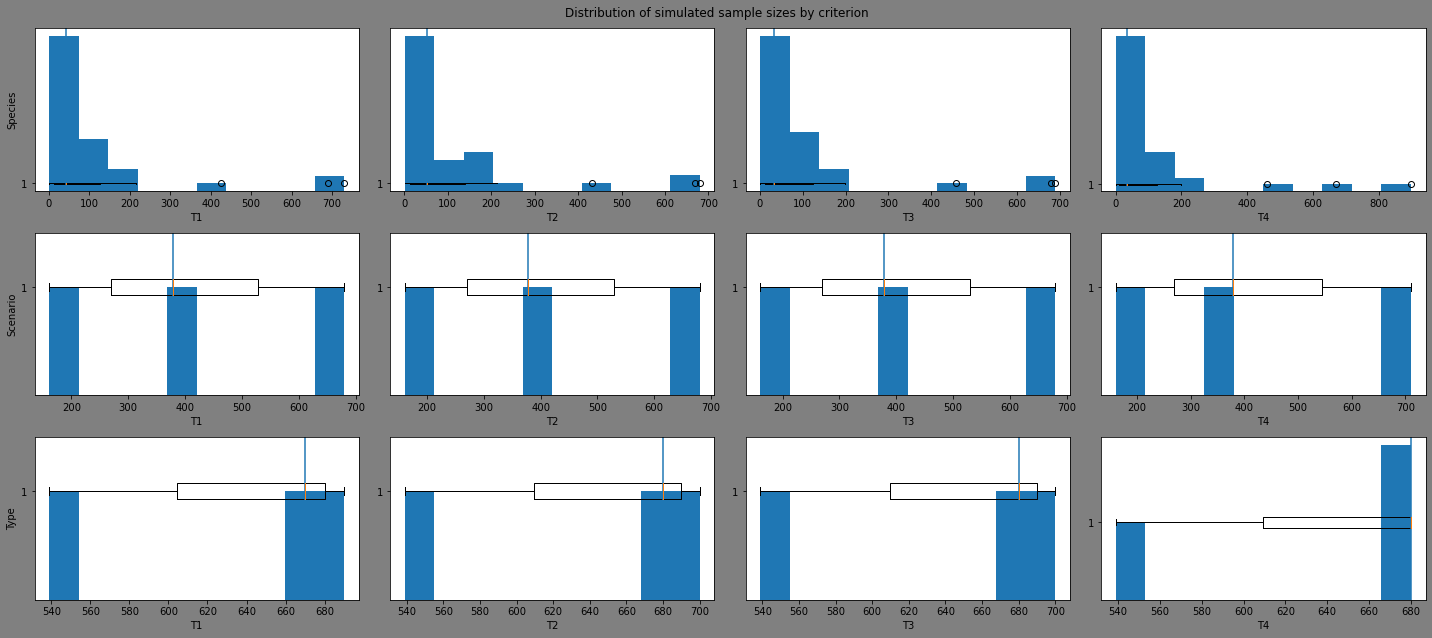

In [127]:
main('t4_clean.p', group_cols, sim_cols, labels=english)

Partitioning data...


[                                                                        ]   0%

Done!
Simulating...


[======================================================================= ]  98%

Creating result dict...
Done!
Converting results...
Done!
{'Especie': 240, 'Escenario': 770, 'Tipo': 760}
Especie 2457 0.38
Escenario 1234 0.69
Tipo 1758 0.56
3190 0.2
3986


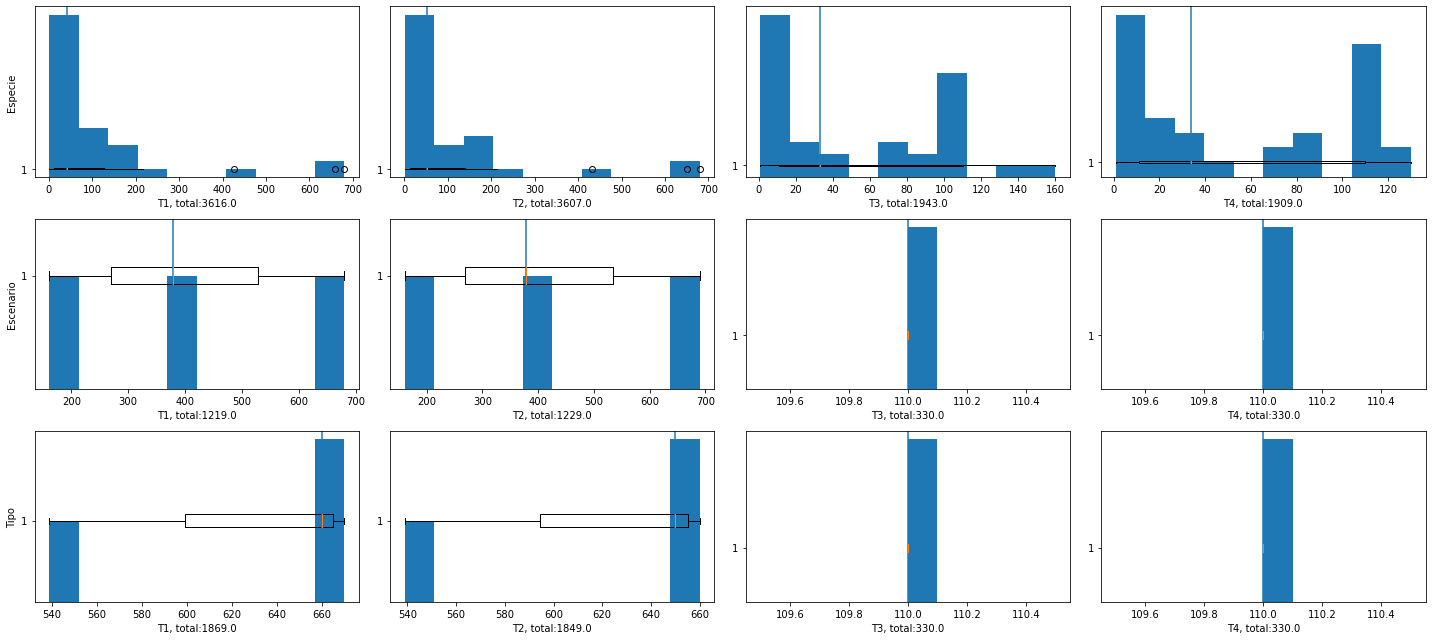

In [34]:
# Modeling with only quantitative columns
main('t4_clean.p', group_cols, quants, labels=english)

{'Especie': 180, 'Escenario': 110, 'Tipo': 110}
Especie 2185 0.45
Escenario 281 0.93
Tipo 313 0.92
2369 0.41
3986


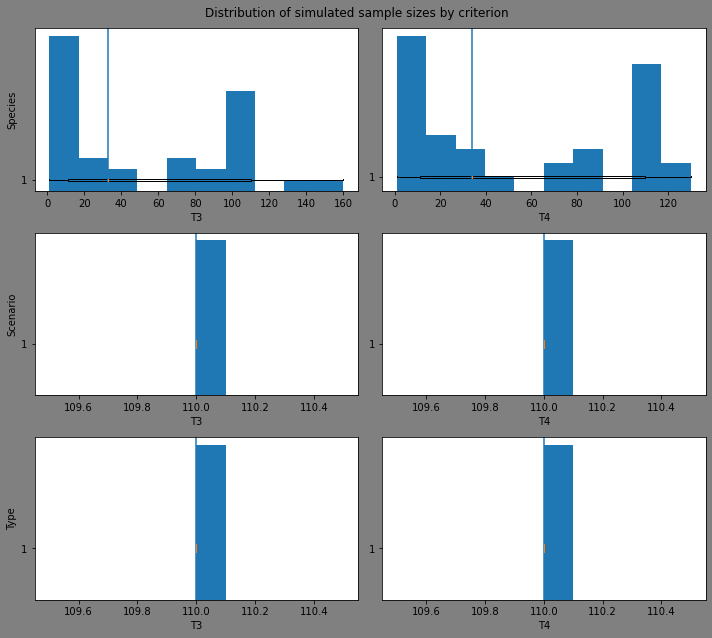

In [99]:
# Quantitative columns for the last two events
df_dict, limits = calculate_improvement(permutation_df, group_cols, quants, events=['T3', 'T4'], labels=english)
sample_list = create_sample_list(df, limits)
final_set = set()
pop_size = df[df['Even_mon'] == events[-1]].shape[0]
for key in sample_list:
    print(key, len(sample_list[key]), round(1-len(sample_list[key])/pop_size, 2))
    final_set.update(sample_list[key])
print(len(final_set), round(1-len(final_set)/pop_size, 2))
print(pop_size)


In [99]:
# Save data
permutation_df.to_pickle('tight.p')
loose_permutation_df.to_pickle('loose.p')